## Use Case : ManoMano : Explanation of my approach 

### Import Libraries

In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from typing import List, Tuple, Union, Dict
from tqdm import tqdm
from datetime import date

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
import re
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')

warnings.filterwarnings('ignore')

sns.set()

[nltk_data] Downloading package stopwords to /home/oem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading data: 

In [2]:
train_drug = pd.read_csv('data/manomano-ml-technical-junior/drugs_train.csv')
drug_label_feature_eng = pd.read_csv('data/manomano-ml-technical-junior/drug_label_feature_eng.csv')
train_drug.drop_duplicates(inplace=True)
drug_label_feature_eng.drop_duplicates(inplace=True)

In [3]:
train_drug.head()

,drug_id,description,administrative_status,approved_for_hospital_use,reimbursement_rate,marketing_declaration_date,marketing_authorization_date,marketing_authorization_process,pharmaceutical_companies,price
0,0_train,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,Présentation active,oui,65%,20140101,20140101,Procédure décentralisée,MAJORELLE LUXEMBOURG SOPARFI (LUXEMBOURG),2.83
1,1_train,plaquette(s) thermoformée(s) aluminium de 28 c...,Présentation active,oui,65%,20130101,20090101,Procédure de reconnaissance mutuelle,TEVA SANTE,14.30
2,2_train,plaquette(s) thermoformée(s) PVC-aluminium de ...,Présentation active,oui,65%,20000101,19960101,Procédure nationale,MYLAN SAS,5.66
3,3_train,30 sachet(s)-dose(s) papier aluminium complexe...,Présentation active,oui,65%,20050101,20040101,Procédure nationale,SANOFI AVENTIS FRANCE,24.27
4,4_train,plaquette(s) thermoformée(s) PVC-Aluminium de ...,Présentation active,non,100%,20150101,20100101,Procédure nationale,TEVA SANTE,59.94


In [4]:
drug_label_feature_eng.head()

,description,label_plaquette,label_ampoule,label_flacon,label_tube,label_stylo,label_seringue,label_pilulier,label_sachet,label_comprime,...,count_stylo,count_seringue,count_pilulier,count_sachet,count_comprime,count_gelule,count_film,count_poche,count_capsule,count_ml
0,12 sachet(s) papier aluminium polyéthylène de ...,0,0,0,0,0,0,0,1,0,...,0,0,0,12,0,0,0,0,0,0.0
1,plaquette(s) thermoformée(s) (ACLAR RX) polytr...,1,0,0,0,0,0,0,0,1,...,0,0,0,0,28,0,0,0,0,0.0
2,tube(s) polypropylène dioxyde de titane de 30 ...,0,0,0,1,0,0,0,0,1,...,0,0,0,0,30,0,0,0,0,0.0
3,plaquette(s) thermoformée(s) polyamide alumini...,1,0,0,0,0,0,0,0,1,...,0,0,0,0,20,0,0,0,0,0.0
4,1 flacon(s) pressurisé(e)(s) aluminium de 120 ...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0


In [5]:
def process_description(data):
    descriptions = data.description.tolist()
    def get_material(description):
        desc = description.split(" ")
        try: 
            int(desc[0])
            return desc[2]
        except:
            return desc[1]
    materials = {}
    for d in descriptions:
        if materials.get(get_material(d), False):
            materials[get_material(d)] += 1
        else:
            materials[get_material(d)] = 1
    print(materials)
    return [get_material(d) for d in descriptions]

In [6]:
train_drug.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8564 entries, 0 to 8563
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   drug_id                          8564 non-null   object 
 1   description                      8564 non-null   object 
 2   administrative_status            8564 non-null   object 
 3   approved_for_hospital_use        8564 non-null   object 
 4   reimbursement_rate               8564 non-null   object 
 5   marketing_declaration_date       8564 non-null   int64  
 6   marketing_authorization_date     8564 non-null   int64  
 7   marketing_authorization_process  8564 non-null   object 
 8   pharmaceutical_companies         8564 non-null   object 
 9   price                            8564 non-null   float64
dtypes: float64(1), int64(2), object(7)
memory usage: 736.0+ KB


In [7]:
drug_label_feature_eng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   description      3000 non-null   object 
 1   label_plaquette  3000 non-null   int64  
 2   label_ampoule    3000 non-null   int64  
 3   label_flacon     3000 non-null   int64  
 4   label_tube       3000 non-null   int64  
 5   label_stylo      3000 non-null   int64  
 6   label_seringue   3000 non-null   int64  
 7   label_pilulier   3000 non-null   int64  
 8   label_sachet     3000 non-null   int64  
 9   label_comprime   3000 non-null   int64  
 10  label_gelule     3000 non-null   int64  
 11  label_film       3000 non-null   int64  
 12  label_poche      3000 non-null   int64  
 13  label_capsule    3000 non-null   int64  
 14  count_plaquette  3000 non-null   int64  
 15  count_ampoule    3000 non-null   int64  
 16  count_flacon     3000 non-null   int64  
 17  count_tube    

The first thing to do is to apply a left join on the train_drug with the drug_label_feature_eng dataframe in order to get a table with more features.

In [8]:
data = pd.merge(train_drug, drug_label_feature_eng, on="description", how="left")

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8564 entries, 0 to 8563
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   drug_id                          8564 non-null   object 
 1   description                      8564 non-null   object 
 2   administrative_status            8564 non-null   object 
 3   approved_for_hospital_use        8564 non-null   object 
 4   reimbursement_rate               8564 non-null   object 
 5   marketing_declaration_date       8564 non-null   int64  
 6   marketing_authorization_date     8564 non-null   int64  
 7   marketing_authorization_process  8564 non-null   object 
 8   pharmaceutical_companies         8564 non-null   object 
 9   price                            8564 non-null   float64
 10  label_plaquette                  8052 non-null   float64
 11  label_ampoule                    8052 non-null   float64
 12  label_flacon        

**Observations et constations:** 

We can see here that after merging dataframes there is some missing values that appears in the data. One can fill them by processing their corresponding description and find for wich label they belongs and the corresponding quantity.

The objective here is to predict the price for each drug which is a numerical (real) data and therefore we are facing a **regression supervised problem**.

the metrics to be based on are :

- MSE as a loss 
- r2-score as to mesure the precision of the model

### EDA : Exploratory data analysis : 

The first thing to do is to distinguish the different types of variables in the data, i.e. to see if they are categorical, numerical or ordinal variables.

- **Categorical variable**  is a variable that can take on one of a limited, and usually fixed, number of possible values, the question now is to find the threshold value to set. **One will assume that the threshold value at which we will not consider the variable as categorical is 10.**

- **numerical variable** is a quantifiable characteristic whose values are numbers (except numbers which are codes standing up for categories). Numeric variables may be either continuous or discrete

- **Ordinal variable** An ordinal variable is a variable whose values are defined by an order relation between the different categories.

In [10]:
y = data["price"]
X = data.drop(columns=['price'])

The first thing to do is to remove the ids column.

In [11]:
X.drop(columns=["drug_id"], inplace=True)

#### Identify categorical variables : 

In [12]:
def categorical_var_preselection(data: pd.DataFrame, threshold: int = 10) -> List[str]:
    """
    Preselect Categorical variables
    """
    return [c for c in data.columns if data[c].nunique() <= threshold]

In [13]:
categorical_variables = categorical_var_preselection(X)
print("Preselected Categorical variables : \n - {}".format("\n - ".join(categorical_variables)))

Preselected Categorical variables : 
 - administrative_status
 - approved_for_hospital_use
 - reimbursement_rate
 - marketing_authorization_process
 - label_plaquette
 - label_ampoule
 - label_flacon
 - label_tube
 - label_stylo
 - label_seringue
 - label_pilulier
 - label_sachet
 - label_comprime
 - label_gelule
 - label_film
 - label_poche
 - label_capsule
 - count_tube
 - count_stylo
 - count_pilulier
 - count_film


From the preselected columns, we can consider as categorical variables the following columns :

- administrative_status
- approved_for_hospital_use
- reimbursement_rate
- marketing_authorization_process
- label_plaquette
- label_ampoule
- label_flacon
- label_tube
- label_stylo
- label_seringue
- label_pilulier
- label_sachet
- label_comprime
- label_gelule
- label_film
- label_poche
- label_capsule

In [14]:
X["pharmaceutical_companies"].nunique()

325

**Remark :** the column **pharmaceutical_companies** is a categorical variables because it takes a finite number of values, but it's not preselected because the number a values taken are consequently huge.

In [15]:
categorical_variables = ["administrative_status", "approved_for_hospital_use", "reimbursement_rate",
"marketing_authorization_process", "label_plaquette", "label_ampoule",
"label_flacon", "label_tube", "label_stylo",
"label_seringue", "label_pilulier", "label_sachet",
"label_comprime", "label_gelule", "label_film",
"label_poche", "label_capsule", "pharmaceutical_companies"]

In [16]:
categorical_variables_apply_get_dummies = ["administrative_status", 
"approved_for_hospital_use", "reimbursement_rate",
"marketing_authorization_process", "pharmaceutical_companies"]

**Identify numerical and ordinal variables:**

As I mentioned it above, the numerical and ordinal variables take integer or real values.the first thing to do is to eliminate the columns identified as categorical and select from those that remain, those that would qualify as numeric.

In [17]:
df = X.drop(categorical_variables, axis=1)

In [18]:
def numerical_var_preselection(data: pd.DataFrame) -> List[str]:
    return data.describe().columns

In [19]:
numerical_variables = numerical_var_preselection(df)
print("Preselected Numerical variables : \n - {}".format("\n - ".join(numerical_variables)))

Preselected Numerical variables : 
 - marketing_declaration_date
 - marketing_authorization_date
 - count_plaquette
 - count_ampoule
 - count_flacon
 - count_tube
 - count_stylo
 - count_seringue
 - count_pilulier
 - count_sachet
 - count_comprime
 - count_gelule
 - count_film
 - count_poche
 - count_capsule
 - count_ml


**Observations :** 
- There is no ordinal variable in the dataframe.

- **marketing_authorization_date** and **marketing_declaration_date** are defined as interger but it's not the right format. One should transform them to datetime.

In [20]:
numerical_variables = ["count_plaquette", "count_ampoule", "count_flacon",
"count_tube", "count_stylo", "count_seringue",
"count_pilulier", "count_sachet", "count_comprime",
"count_gelule", "count_film", "count_poche", 
"count_capsule", "count_ml"]
datetime_variables = ["marketing_declaration_date", "marketing_authorization_date"]

#### Exploring description column

In [21]:
descriptions = data["description"]
french_stopwords = stopwords.words('french')

def compute_occurence(descriptions: List[str]) -> Dict[str, int]:
    occurence = {}
    for description in descriptions:
        description = re.sub("[^A-Za-zàâäçéèêëîïôöùûü\- ]","", description)
        for word in description.split(' '):
            if word not in french_stopwords + [" ", ""]:
                if occurence.get(word, False):
                    occurence[word] += 1
                else:
                    occurence[word] = 1
    return occurence
occurence = compute_occurence(descriptions)
occ_1000 = {k: v for k, v in occurence.items() if v > 1000}
print("Words with occurence greater than 1000 : \n", occ_1000)


Words with occurence greater than 1000 : 
 {'plaquettes': 6038, 'thermoformées': 5208, 'PVC-Aluminium': 1656, 'comprimés': 5445, 'aluminium': 4731, 'gélules': 1090, 'flacons': 1219, 'polyéthylène': 1721, 'PVC': 2886, 'PVDC': 2231, 'verre': 1122, 'ml': 1303}


After removing all stopwords in the description column and by computing the occurence of words, we can see that the most frequent words are those related to the material the drug containers.
It seems relevant to add them as feature.
I will select the following terms to add them as features :
 - thermoformées
 - aluminium
 - pvc
 - pvdc
 - verre 

#### Dealing with Nan values:

In [22]:
def get_columns_with_nan_values(data: pd.DataFrame) -> List[str]:
    nb_lines = data.shape[0]
    return [c for c in data.columns if data[c].count() < nb_lines]

In [23]:
cols_with_nans = get_columns_with_nan_values(X)

In [24]:
def info_nan_col(data: pd.DataFrame, cols: List[str]) -> List[str]:
    return [" - ".join([c, "type : " + str(X[c].dtype), f"ratio nan : {round((1 - data[c].count()/data.shape[0]) * 100, 2)} %" ]) for c in cols_with_nans]
print("Columns with nan values : \n - {}".format("\n - ".join(info_nan_col(data, cols_with_nans))))

Columns with nan values : 
 - label_plaquette - type : float64 - ratio nan : 5.98 %
 - label_ampoule - type : float64 - ratio nan : 5.98 %
 - label_flacon - type : float64 - ratio nan : 5.98 %
 - label_tube - type : float64 - ratio nan : 5.98 %
 - label_stylo - type : float64 - ratio nan : 5.98 %
 - label_seringue - type : float64 - ratio nan : 5.98 %
 - label_pilulier - type : float64 - ratio nan : 5.98 %
 - label_sachet - type : float64 - ratio nan : 5.98 %
 - label_comprime - type : float64 - ratio nan : 5.98 %
 - label_gelule - type : float64 - ratio nan : 5.98 %
 - label_film - type : float64 - ratio nan : 5.98 %
 - label_poche - type : float64 - ratio nan : 5.98 %
 - label_capsule - type : float64 - ratio nan : 5.98 %
 - count_plaquette - type : float64 - ratio nan : 5.98 %
 - count_ampoule - type : float64 - ratio nan : 5.98 %
 - count_flacon - type : float64 - ratio nan : 5.98 %
 - count_tube - type : float64 - ratio nan : 5.98 %
 - count_stylo - type : float64 - ratio nan : 5.

**Conclusions :**


- For all the above columns, the missing values can only be filled in by exploring the text description of the drugs.

In [25]:
class FillNan:
    def __init__(self, X, y, label_columns, count_columns):
        self.data = X.copy()
        self.data["label"] = y.tolist()
        self.label_columns = label_columns
        self.count_columns = count_columns

        # get the rows with nan values :
        self.rows_with_nan = self._find_indexes_with_nan_val()


    def _find_indexes_with_nan_val(self):
        """
        Find indices with nan values.
        """
        rows_with_nan = []
        for index, row in self.data.iterrows():
            is_nan_series = row.isnull()
            if is_nan_series.any():
                rows_with_nan.append(index)
        return rows_with_nan
    
    def _fill_labels(self):
        """
        Fill label_* columns with nan values 
        """
        
        for label in tqdm(self.label_columns):
            for row in self.rows_with_nan:
                if label.replace("label_", "") in self.data.description.loc[row]:
                    self.data[label].loc[row] = 1
                else:
                    self.data[label].loc[row] = 0
    
    def _fill_counts(self):
        """
        Fill count_* columns with nan values 
        """
        
        def get_count(label, description):
            description = " ".join([d for d in description.split(" ") if d not in ["", " ", None]])
            for i, word in enumerate(description.split(' ')):
                if label.lower() in word.lower():
                    if i == 0:
                        return 1
                    else:
                        try:
                            return float(description.split(' ')[i-1].replace(",", "."))
                        except:
                            return 1 
            return 0
        
        for count in tqdm(self.count_columns):
            for row in self.rows_with_nan:
                if count.replace("count_", "") not in self.data.description.loc[row].replace("é", "e"):
                    self.data[count].loc[row] = 0
                else:
                    self.data[count].loc[row] = get_count(count.replace("count_", ""), self.data["description"].loc[row].replace("é", "e"))
                
    def fillna(self) -> pd.DataFrame:
        # Fill label_* columns with nan values 
        self._fill_labels()
        # Fill count_* columns with nan values 
        self._fill_counts()
        y = self.data["label"]
        X = self.data.drop(columns=['label'])
        return X, y

In [26]:
# columns which begin by label_ : 
label_columns = list(X.loc[:, X.columns.str.startswith('label_')].columns)

# columns which begin by count_ : 
count_columns = list(X.loc[:, X.columns.str.startswith('count_')].columns)

fillna = FillNan(X, y, label_columns, count_columns)

In [27]:
X, y = fillna.fillna()

100%|███████████████████████████████████████████| 14/14 [01:35<00:00,  6.85s/it]


## Feature engineering : 

In [28]:
class FeatureEngineering:
    def __init__(self, data: pd.DataFrame, categorical_cols: List[str]) -> None:
        self.data = data.copy()
        self.categorical_cols = categorical_cols

    # Extract Day, Month, year for both marketing declation and marketing authorization
    def _split_date(self) -> None:
        # I observed that the date is set for the 1st january of the year but to generalize 
        # I will extract the day and the month from the date
#         self.data["marketing_authorization_day"] = self.data["marketing_authorization_date"]%100
#         self.data["marketing_authorization_month"] = (self.data["marketing_authorization_date"]//100)%100
        self.data["marketing_authorization_year"] = self.data["marketing_authorization_date"]//10000
            
        
#         self.data["marketing_declaration_day"] = self.data["marketing_declaration_date"]%100
#         self.data["marketing_declaration_month"] = (self.data["marketing_declaration_date"]//100)%100
        self.data["marketing_declaration_year"] = self.data["marketing_declaration_date"]//10000

    # Convert to datetime and compute the duration column:
    def _compute_period_of_validity(self) -> None:
        
#         def to_datetime(date_in_float):
#             day = date_in_float % 100
#             month = (date_in_float // 100) % 100
#             year = date_in_float // 10000
#             return date(year, month, day)
    
#         declaration_date = self.data["marketing_declaration_date"].apply(lambda x : to_datetime(x))
#         authorization_date = self.data["marketing_authorization_date"].apply(lambda x : to_datetime(x))

        self.data.drop(columns=["marketing_authorization_date"], inplace=True)
        self.data.drop(columns=["marketing_declaration_date"], inplace=True)
        duration  = self.data["marketing_declaration_year"] - self.data["marketing_authorization_year"] 
        self.data["period_validity"] = duration
   
    # Add other columns based on description exploration:
    #     - is_thermoformee
    #     - is pvc
    #     - is aluminium
    #     - is verre
    #     - is PVDC

    def _is_thermoformee(self) -> None:
        self.data["is_thermoforme"] = self.data["description"].apply(lambda x : 1 if "thermoformé" in x.lower() else 0)

    def _is_pvc(self) -> None:
        self.data["is_pvc"] = self.data["description"].apply(lambda x : 1 if "pvc" in x.lower() else 0)

    def _is_aluminium(self) -> None:
        self.data["is_aluminium"] = self.data["description"].apply(lambda x : 1 if "aluminium" in x.lower() else 0)

    def _is_pvdc(self) -> None:
        self.data["is_pvdc"] = self.data["description"].apply(lambda x : 1 if "pvdc" in x.lower() else 0)
    
    def _is_verre(self) -> None:
        self.data["is_verre"] = self.data["description"].apply(lambda x : 1 if "pvc" in x.lower() else 0)

    def _process_categorical_data(self) -> None:
        self.data = pd.get_dummies(self.data, columns=self.categorical_cols, drop_first=True)

    def transform(self) -> pd.DataFrame:
        """
        Apply all transformations
        """
        # Add date features : 
        self._split_date()
        
        # Apply get dummies for categorical data
        self._process_categorical_data()
        
        # Compute validity period :
        self._compute_period_of_validity()
        
        # Add is thermoformee:
        self._is_thermoformee()
        
        # Add is PVC
        self._is_pvc()
        
        # Add is PVCD
        self._is_pvdc()
        
        # Add is verre
        self._is_verre()
        
        # Add is aluminium
        self._is_aluminium() 
        
        # Drop description column 
        self.data.drop(columns=["description"], inplace=True)
        return self.data


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [30]:
fe = FeatureEngineering(X_train, categorical_variables_apply_get_dummies)
X_train = fe.transform()

fe = FeatureEngineering(X_test, categorical_variables_apply_get_dummies)
X_test = fe.transform()

In [31]:
print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)

X_train shape :  (8135, 366)
X_test shape :  (429, 155)


## Eliminate redundancy :

Studying the redundancy of information is studying the correlation between the different variables. The more the variables are correlated, the more redundancy there is and thus leads to a deterioration of the model.

To study the correlation between variables, I will draw up their correlation matrix:

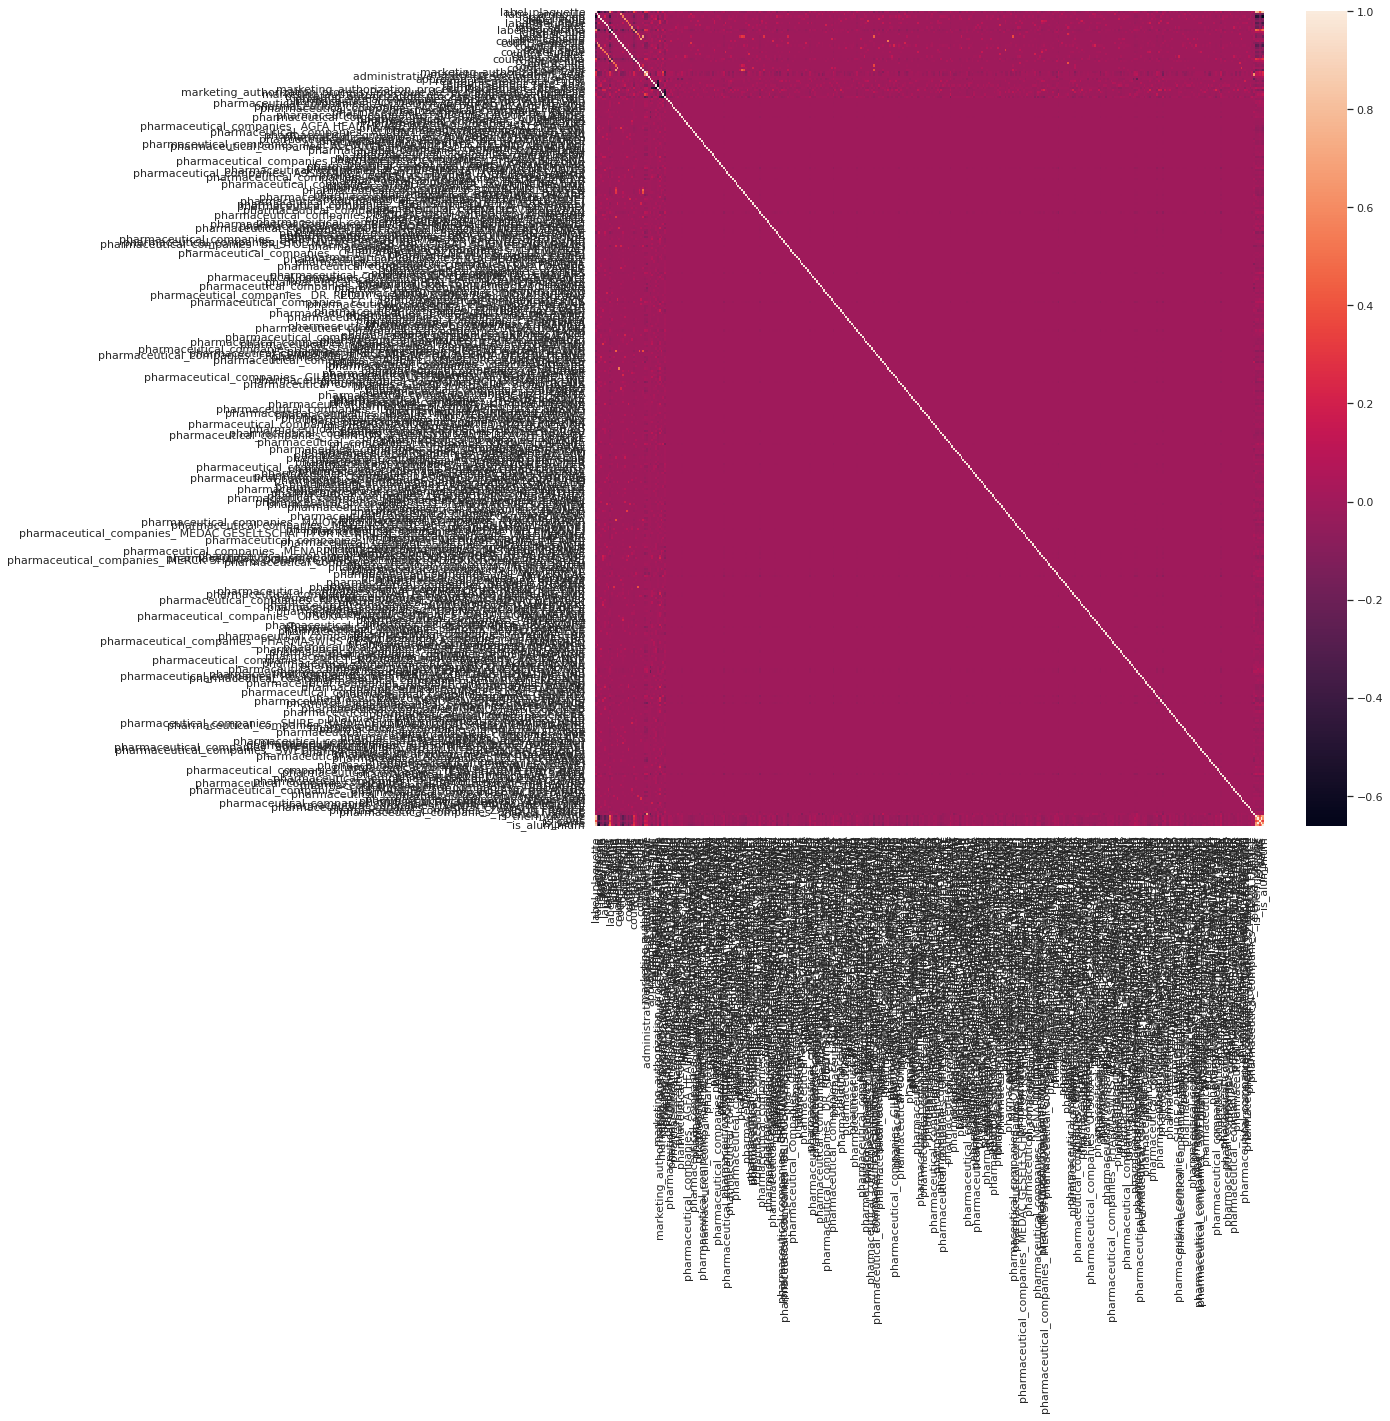

In [32]:
corr = X_train.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns);

In [33]:
# I will consider that to variables are correlated if absolute correlation value is up to 80% :
correlated = [(i,j) for i in corr.columns for j in corr.columns if i>j and abs(corr[i][j]) >= 0.8]

In [34]:
print("Correlated tuples :")
for c in correlated:
    print(f' - {c[0]}, {c[1]}')

Correlated tuples :
 - label_plaquette, is_thermoforme
 - label_plaquette, is_aluminium
 - is_verre, is_pvc


Based on the correlation mesure, we need to drop the following columns in order to avoid redundancy: 

- label_plaquette
- administrative_status_Présentation abrogée
- approved_for_hospital_use_non
- is_verre

In [35]:
X_train.loc[:, X_train.columns.str.startswith('approved')].columns

Index(['approved_for_hospital_use_oui'], dtype='object')

In [36]:
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_àâäçéèêëîïôöùûü]+', '_', x))
columns_to_drop = ["label_plaquette", "is_verre"]
X_train.drop(columns=columns_to_drop, inplace=True)

## Feature Selection

In [37]:
class feature_selection:

    def __init__(self) -> None:
        self.columns = None
        self.columns_deleted = []

    def _compute_r2_score(self, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series) -> Tuple[float, float, float]:
        """
        Input : 
            - X_train : Training dataframe
            - X_test  : Test dataframe 
            - y_train : Training labels
            - y_test  : Test labels
        
        output:
            - r2_lgbm : r2 score for lgbm model 
            - r2_rf : r2 score for random forest
            - r2_svr : r2 score for svm regressor
        """
                
        # r2-score for lgmb model :
        r2_lgbm = r2_score(y_test, LGBMRegressor().fit(
            X_train, y_train).predict(X_test))
        return r2_lgbm
    
    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        """
        Input : 
            - X : The full data
        """
        df = X.copy()
        columns = list(df.columns)

        size = 1000 
        j = 0
        
        cols_len = len(columns)
        print("len cols : ", cols_len)
        prog = 0
        while (j < len(columns)-1 and len(columns) > 1):
            # splitting data :
            X_train, X_test, y_train, y_test = train_test_split(X[columns], y, test_size=0.2, random_state=42)
            
            # ------------------------------------------------------------------
            # Computing f1-scores with the full data :
            # ------------------------------------------------------------------
            
            full_r2_lgbm = self._compute_r2_score(X_train, X_test, y_train, y_test)
            
            # ------------------------------------------------------------------
            # Removing the jth column and try to observe the impact on f1-score :
            # ------------------------------------------------------------------
            col = columns[j]
            columns.remove(col)

            X_train = X_train[columns]
            X_test = X_test[columns]
            
            r2_lgbm = self._compute_r2_score(X_train, X_test, y_train, y_test)

            if full_r2_lgbm <= r2_lgbm:
                columns.insert(j, col)
            else:
                self.columns_deleted.append(col)
                
            j += 1
            prog += 1
            print(f'progress {round(prog / cols_len * 100, 2)} % : ' + '#' * round(prog / cols_len * 100 / 2 ), end='\r')
        self.columns = columns

    def transform(self, X):
        return X[self.columns]

In [38]:
cr_feature = feature_selection()
cr_feature.fit(X_train, y_train)

X_train = cr_feature.transform(X_train)
# X_test = cr_feature.transform(X_test)

len cols :  364


## Find the best model :

In [39]:
def score_regressor(dataset, classifier, labels):
    
    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    Inputs :
        - dataset : the dataset to work on
        - classifier : the classifier to use
        - labels : the labels used for training and validation
    :return:
    """
    n_splits = 5
    kf = KFold(n_splits=n_splits, random_state=50, shuffle=True)
    r2_scores = []
    mse_list = []
    
    
    for training_ids, test_ids in kf.split(dataset):
        
        if type(dataset) == pd.DataFrame:
            
            training_set = dataset.loc[training_ids]
            training_labels = labels.loc[training_ids]

            test_set = dataset.loc[test_ids]
            test_labels = labels.loc[test_ids]
            
        elif type(dataset) == np.ndarray: 
            
            training_set = dataset[training_ids]
            training_labels = labels[training_ids]

            test_set = dataset[test_ids]
            test_labels = labels[test_ids]
            
        
        classifier.fit(training_set, training_labels)
        
        predicted_labels = classifier.predict(test_set)
        
        r2_scores.append(r2_score(test_labels, predicted_labels))
        mse_list.append(mean_squared_error(test_labels, predicted_labels))
    
    
    r2_sc = np.mean(r2_scores)
    mse_list = np.mean(mse_list, axis=0)
    
    print(f"R2 Score = {r2_sc}")
    print(f"MSE : \n {mse_list}")

    print("############################")
    return r2_sc

In [40]:
dic = {
       'SVR': SVR, 
       'RandomForestRegressor': RandomForestRegressor, 
       'LGBMRegressor': LGBMRegressor,
       'XGBRegressor':XGBRegressor,
       'DecisionTreeRegressor':DecisionTreeRegressor
       }

models_with_scaling = [SVR]

best_m =''
best_sc = 0

for model in dic:
    if dic[model] in models_with_scaling:
        scaler = MinMaxScaler()
        X_scal = scaler.fit_transform(X_train)
        print("Model : {} \n".format(model))
        score = score_regressor(X_scal, dic[model](), y_train)
        if score > best_sc:
            best_sc = score
            best_m = model
    else:        
        print("Model : {} \n".format(model))
        score = score_regressor(X_train, dic[model](), y_train)
        if score > best_sc:
            best_sc = score
            best_m = model

Model : SVR 

R2 Score = 0.06537089372869968
MSE : 
 6375.081770912259
############################
Model : RandomForestRegressor 

R2 Score = 0.5372970884358519
MSE : 
 3140.606205008445
############################
Model : LGBMRegressor 

R2 Score = 0.4338368087706142
MSE : 
 3821.7453179277763
############################
Model : XGBRegressor 

R2 Score = 0.5536758177810535
MSE : 
 3028.1658601122444
############################
Model : DecisionTreeRegressor 

R2 Score = 0.4517350631296805
MSE : 
 3689.4774072742366
############################


In [41]:
print('the best model is {} with r2-score {} %'.format(best_m,round(best_sc*100,2)))

the best model is XGBRegressor with r2-score 55.37 %


## Tuning hypermarameters:

Having chosen the most appropriate model to the problem, It remains to find the appropriate parameters that allow us to have the highest score. There are mainly 3 known methods of tuning hyperparameters which are gridsearch, randomsearch and Bayesian search. For this case, I chose the simplest approach which is the Gridsearch.

In [42]:
rg = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={'num_leaves': (15, 30, 45),
                'max_depth': (-1, 5, 10, 20),
                'learning_rate': (0.05, 0.1, 0.2, 0.4),
                'n_estimators': (25, 50, 100, 200),
                },
    scoring="r2",
    cv=3,
    n_jobs=3,
    verbose=1,
    refit=True)

rg.fit(X_train,y_train)


Fitting 3 folds for each of 192 candidates, totalling 576 fits
[00:42:44] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:42:45] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:42:46] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed d

[00:42:44] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:42:45] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:42:46] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[00:44:08] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:44:16] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:44:30] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[00:47:44] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:47:45] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:47:47] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[00:48:25] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:48:28] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:48:29] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[00:51:01] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:51:27] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:51:53] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[00:53:18] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:20] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:22] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[00:53:24] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:27] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:31] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[00:57:38] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:43] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:48] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  bu

[01:02:32] WARNING: ../src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [43]:
best_model = XGBRegressor(**rg.best_params_)

## Applying model on test set :

The problem that arises here is the application of the get_dummies which makes the number of obtained columns  on the training set not equal to those on the test set. 
Two approaches are possible here:

- We take the intersection of the columns between X_train and X_test
- We keep the same number of columns as the X_train: 
    - If there are missing values on the test set we add them as vectors whose value is 0 
    - If there are values which are in the test set and not in the train set we eliminate them. 

I chose the first solution because of the computation time since we have a consequent number of columns due to the get_dummies application. the intersection will allow to obtain a matrix with less consequent size without a real lose of performance. 


In [44]:
def predict(model, X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series):
    """
    input:
        - model : model after tuning hyperparameters
        - X_train : training set dataframe after feature engineering
        - y_train : ground truth of the trianing set
        - X_test : test set dataframe after feature engineering
    output : 
        
    """
    X_tr = X_train.copy()
    X_ts = X_test.copy()

    # Remove duplicate columns :
    X_tr = X_tr.loc[:,~X_tr.columns.duplicated()]
    X_ts = X_ts.loc[:,~X_ts.columns.duplicated()]
    
    def intersection(lst1: List[str], lst2: list):
        return list(set(lst1) & set(lst2))
    
    # Get columns intersection : 
    cols = intersection(list(X_tr.columns), list(X_ts.columns))
    
    X_tr = X_tr[cols]
    X_ts = X_ts[cols]

    
    assert list(X_tr.columns) == list(X_ts.columns)
    
    model.fit(X_tr, y_train)
    return model.predict(X_ts)

In [45]:
y_pred = predict(best_model, X_train, X_test, y_train, y_test)

In [46]:
print(f'# Accuracy : {r2_score(y_true=y_test, y_pred=y_pred)}')

# Accuracy : 0.42466122232193504
